In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])
print(df.shape)
df.head()


Saving Loan_Default.csv to Loan_Default.csv
(148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [ ]:
TARGET = "Status"
for col in ["ID"]:
    if col in df.columns:
        df = df.drop(columns=[col])
df = df.replace([np.inf, -np.inf], np.nan)
df[TARGET] = df[TARGET].astype(int)

print(df[TARGET].value_counts())


Status
0    112031
1     36639
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((118936, 32), (29734, 32))

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

numeric_process = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_process = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_process, num_cols),
    ('cat', categorical_process, cat_cols)
])

In [ ]:
!pip install -q xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=6, min_samples_leaf=20, min_samples_split=40, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=8,
        min_samples_leaf=15, min_samples_split=30,
        class_weight="balanced", random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=5000, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.6,
        min_child_weight=10,
        gamma=2.0,
        reg_alpha=1.0,
        reg_lambda=5.0,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
    )
}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n🔹 {name} Accuracy: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}



==================== Training Logistic Regression ====================

🔹 Logistic Regression Accuracy: 83.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     22406
           1       0.66      0.71      0.68      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.80      0.79     29734
weighted avg       0.84      0.84      0.84     29734



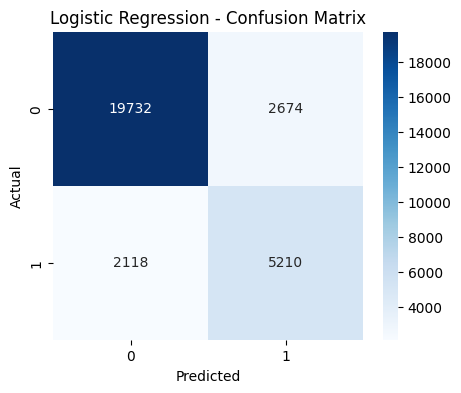


==================== Training Decision Tree ====================

🔹 Decision Tree Accuracy: 99.97%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



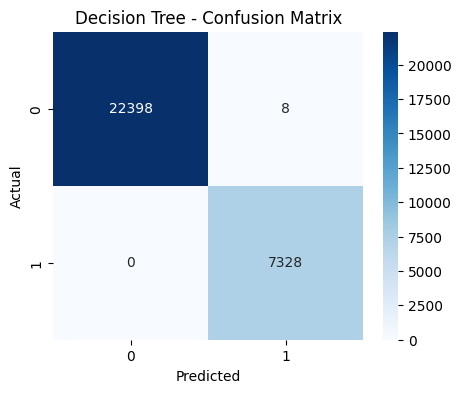


==================== Training Random Forest ====================

🔹 Random Forest Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



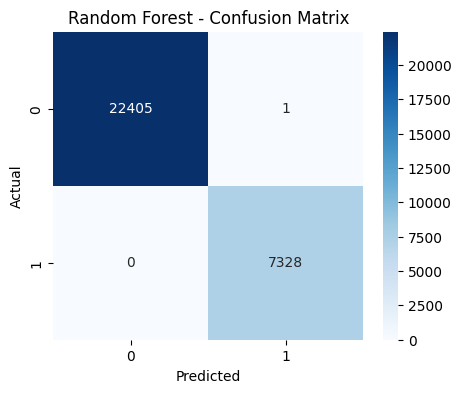


==================== Training Naive Bayes ====================

🔹 Naive Bayes Accuracy: 87.31%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     22406
           1       1.00      0.48      0.65      7328

    accuracy                           0.87     29734
   macro avg       0.93      0.74      0.79     29734
weighted avg       0.89      0.87      0.86     29734



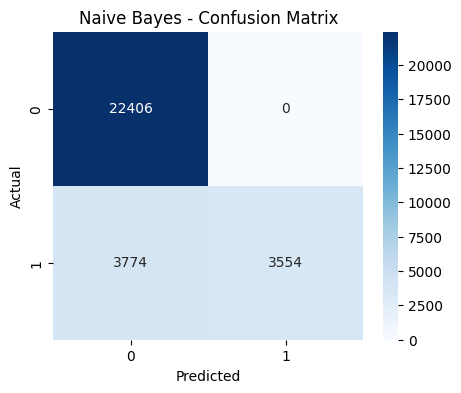


==================== Training Linear SVM ====================

🔹 Linear SVM Accuracy: 83.82%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     22406
           1       0.67      0.69      0.68      7328

    accuracy                           0.84     29734
   macro avg       0.78      0.79      0.78     29734
weighted avg       0.84      0.84      0.84     29734



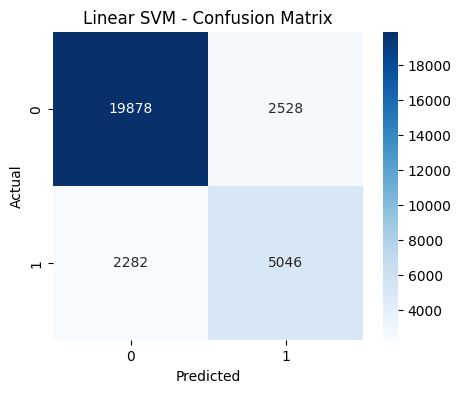


==================== Training XGBoost ====================

🔹 XGBoost Accuracy: 99.99%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



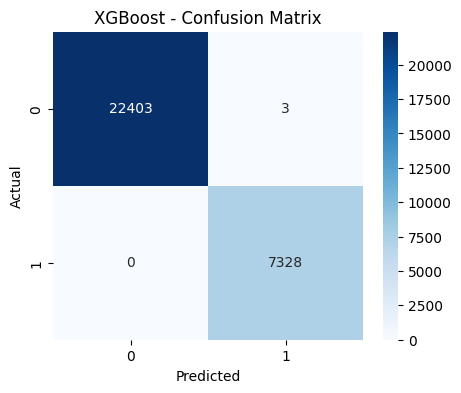

,Model,Accuracy,Precision,Recall,F1,Accuracy %
0,Logistic Regression,0.838838,0.660832,0.710972,0.684986,83.88
1,Decision Tree,0.999731,0.998909,1.000000,0.999454,99.97
2,Random Forest,0.999966,0.999864,1.000000,0.999932,100.00
3,Naive Bayes,0.873075,1.000000,0.484989,0.653189,87.31
4,Linear SVM,0.838232,0.666227,0.688592,0.677225,83.82
5,XGBoost,0.999899,0.999591,1.000000,0.999795,99.99


In [ ]:
results_loan = []

for name, clf in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', clf)
    ])
    print(f"\n==================== Training {name} ====================")
    pipe.fit(X_train, y_train)
    res = evaluate_model(pipe, name, X_test, y_test)
    results_loan.append(res)

results_loan_df = pd.DataFrame(results_loan)
results_loan_df["Accuracy %"] = (results_loan_df["Accuracy"] * 100).round(2)
results_loan_df
